# Model Building [Mock]

## Import Modules

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from imblearn.over_sampling import RandomOverSampler


## Load data

In [15]:
file = "expanded_sample.csv"
df = pd.read_csv(file)
df.head()

,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,cgpa_before,cgpa_after,employment,quit_job,cgpa_change
0,400level,22–24,Female,Single,Management Science,Finance,Yes,Neutral,Poor,Neutral,Poor,Good,Neutral,3.868576,3.521037,Yes,No,-0.347539
1,300level,19–21,Male,Single,Science,Statistics,Yes,Good,Good,Good,Good,Good,Good,3.852298,4.567279,Yes,No,0.714981
2,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,4.169165,4.050938,No,No,-0.118227
3,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,3.537479,3.684619,No,No,0.147139
4,200level,16–18,Female,Married,Engineering,Civil Engineering,No,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,4.087705,3.683059,Yes,No,-0.404646


## Build Models

### Linear Regression

In [5]:
df_lin_reg = df.drop(columns=["cgpa_before", "cgpa_after"])

In [26]:
# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(df_lin_reg.drop(columns="cgpa_change"))
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(df_lin_reg.drop(columns="cgpa_change").columns))
df_lin_reg = pd.concat([df_lin_reg, encoded_df], axis=1)

#### Select features and target

In [27]:
target = "cgpa_change"
X_lr = df_lin_reg.drop(columns=target)
y_lr = df_lin_reg[target]

In [27]:
over_sampler = RandomOverSampler(random_state=42)
# X_lr, y_lr = over_sampler.fit_resample(X_lr, y_lr)
# X_lr.head()

Split data into test and training sets

In [8]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

Split training data into training and validation data

In [9]:
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
        X_train_lr, y_train_lr, test_size=0.2, random_state=42
)

Make pipeline

In [10]:
# create the column transformer to one-hot encode the categorical features
categorical_features = X_lr.columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

In [11]:
# create the linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])


# fit the model to the training data
model.fit(X_train_lr, y_train_lr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['level', 'age', 'gender', 'marital_status', 'faculty', 'department',
       'skill', 'prep_before', 'prep_after', 'quality_before', 'quality_after',
       'confidence_before', 'confidence_after', 'employment', 'quit_job',
       'level_200level', 'level_300level', 'lev...
       'quality_before_Good', 'quality_before_Neutral', 'quality_before_Poor',
       'quality_after_Good', 'quality_after_Neutral', 'quality_after_Poor',
       'confidence_before_Good', 'confidence_before_Neutral',
       'confidence_after_Good', 'confidence_after_Neutral',
       'confidence_after_Poor', 'employment_No', 'employment_Yes',
       'quit_job_No', 'quit_job_Yes', 'quit_job_nan'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [12]:
# evaluate the model's performance on the training data
y_train_lr_mean = y_train_lr.mean()
y_train_lr_baseline = [y_train_lr_mean]*len(y_train_lr)
baseline_mse = mean_squared_error(y_train_lr, y_train_lr_baseline)
training_mse = mean_squared_error(y_train_lr, model.predict(X_train_lr))
print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}""")


Baseline MSE: 0.20356 
Training MSE: 0.20137


In [13]:
# predict the target variable for the validation data
y_pred_val = model.predict(X_val_lr)


# evaluate the model's performance on the validation data
y_val_mean = y_val_lr.mean()
y_val_baseline = [y_val_mean]*len(y_val_lr)
val_mse = mean_squared_error(y_val_lr, y_pred_val)

print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}
Validation MSE: {round(val_mse, 5)}""")


Baseline MSE: 0.20356 
Training MSE: 0.20137
Validation MSE: 0.21994


In [14]:
# perform k-fold cross-validation

scores = cross_val_score(model, X_lr, y_lr, cv=5, scoring='neg_mean_squared_error')

# calculate the mean and standard deviation of the scores
mean_mse = np.mean(-scores)
std_mse = np.std(-scores)

# print the mean and standard deviation of the scores
print(f"Mean MSE: {mean_mse:.5f}")
print(f"Standard deviation of MSE: {std_mse:.5f}")

Mean MSE: 0.20357
Standard deviation of MSE: 0.00945


Text(0, 0.5, 'Residuals')

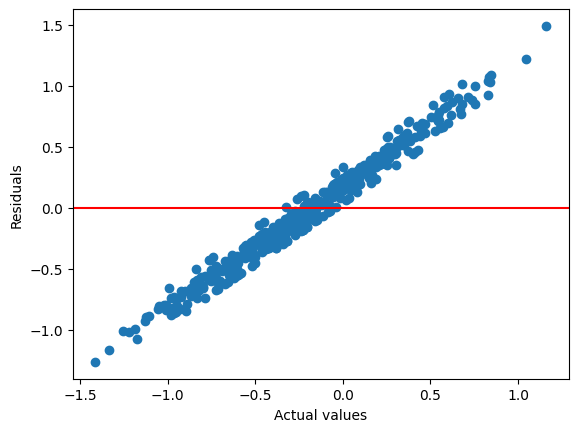

In [15]:
# calculate the residuals
residuals = y_val_lr - y_pred_val

# plot the residuals
plt.scatter(y_val_lr, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual values')
plt.ylabel('Residuals')

In [16]:
# evaluate the model's performance on the test data
mse = mean_squared_error(y_val_lr, y_pred_val)
mse

0.21994373512983717

### Decision Tree Classifier

### Recategorise data

Check only if CGPA dropped or not.

In [17]:
def rise_or_drop(val):  
        
    if val > 0:
        category= 0 # CGPA rose
    else:
        category= 1 # CGPA dropped
    
    return category

In [18]:
def categorize_change(val):
    category = ""

    if abs(val) >= 1:
        category+="EXTREME"
    elif abs(val) >= 0.5:
        category+="VERY HIGH"
    elif abs(val) >= 0.2:
        category+="HIGH"
    elif abs(val) >= 0.1:
        category+="MEDIUM"
    elif abs(val) >= 0.05:
        category+="LOW"
    else:
        category+=" VERY LOW"
        
    if val > 0:
        category+= "-RISE"
    else:
        category+= "-DROP"
    
    return category

In [19]:
cat_df = df.drop(columns=["cgpa_before", "cgpa_after"])
cat_df["cgpa_drop"] = cat_df["cgpa_change"].apply(categorize_change)
cat_df.drop(columns="cgpa_change", inplace=True)

In [20]:
target = "cgpa_drop"
X_dt = cat_df.drop(columns=target)
y_dt = cat_df[target]

In [21]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt= train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(
        X_train_dt, y_train_dt, test_size=0.2, random_state=42
)

In [22]:
acc_baseline = y_train_dt.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.23


In [23]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []
depth_hyperparams = range(1, 50, 2)

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = model = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train_dt, y_train_dt)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train_dt, y_train_dt))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val_dt, y_val_dt))

max_val_acc = max(validation_acc)
optimal_depth = validation_acc.index(max_val_acc) + 6
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])
print("Max Validation Accuracy Score:", max_val_acc)
print("Optimal Depth:", optimal_depth)

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

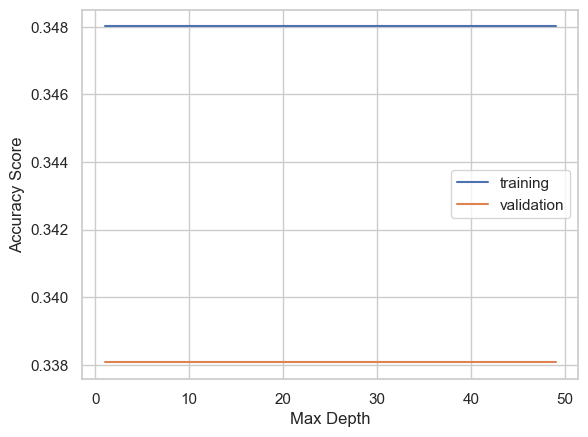

In [ ]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [ ]:
dt_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
)

dt_model.fit(X_train_dt, y_train_dt)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [ ]:
acc_train = accuracy_score(y_train_dt, dt_model.predict(X_train_dt))
acc_val = dt_model.score(X_val_dt, y_val_dt)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.35
Validation Accuracy: 0.34


In [ ]:
features = X_train_dt.columns
importances = dt_model.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail()

level               0.107277
quality_after       0.111645
department          0.173938
confidence_after    0.240107
skill               0.257353
dtype: float64

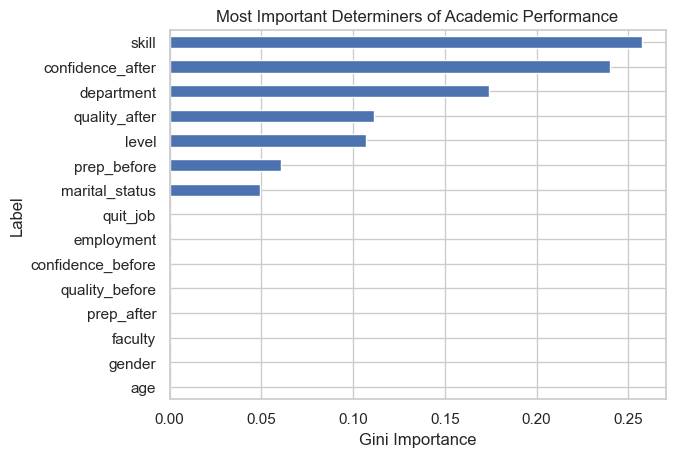

In [ ]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title("Most Important Determiners of Academic Performance");

In [ ]:
predictions = dt_model.predict(X_test_dt)

accuracy_score(predictions, y_test_dt)

0.32045454545454544